In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

%matplotlib inline

Load topics' labels

In [2]:
expanded_features = pd.read_pickle("page_topics_ctrate_expanded_balanced.pkl")
expanded_features = expanded_features.drop("wikicode_len", axis=1).drop("page_id", axis=1).drop("pageviews", axis=1)
expanded_features.head(3)

,Culture.Biography.Biography*,Culture.Biography.Women,Culture.Food and drink,Culture.Internet culture,Culture.Linguistics,Culture.Literature,Culture.Media.Books,Culture.Media.Entertainment,Culture.Media.Films,Culture.Media.Media*,...,STEM.Mathematics,STEM.Medicine & Health,STEM.Physics,STEM.STEM*,STEM.Space,STEM.Technology,ctrate,offset_time_mean,offset_time_median,title
0,0.126773,0.000618,0.001513,0.000531,0.000803,0.003422,0.000958,0.002398,0.000322,0.006528,...,0.000218,0.000692,0.001539,0.731225,0.000369,0.188083,0.029070,37218.4,14275.0,"Ransomes, Sims & Jefferies"
1,0.001954,0.001051,0.000533,0.000383,0.000322,0.000592,0.000190,0.000397,0.000081,0.003174,...,0.000162,0.000248,0.000080,0.004905,0.000058,0.003679,0.010121,10362.2,7609.0,"Milton, Georgia"
2,0.012766,0.011358,0.000039,0.001122,0.000242,0.005665,0.000466,0.002753,0.000788,0.051052,...,0.000174,0.000580,0.008837,0.976763,0.891575,0.988907,0.042105,209884.5,13664.5,Copenhagen Suborbitals


In [3]:
len(expanded_features)

111828

Simple correlation between each feature and the CT rate:

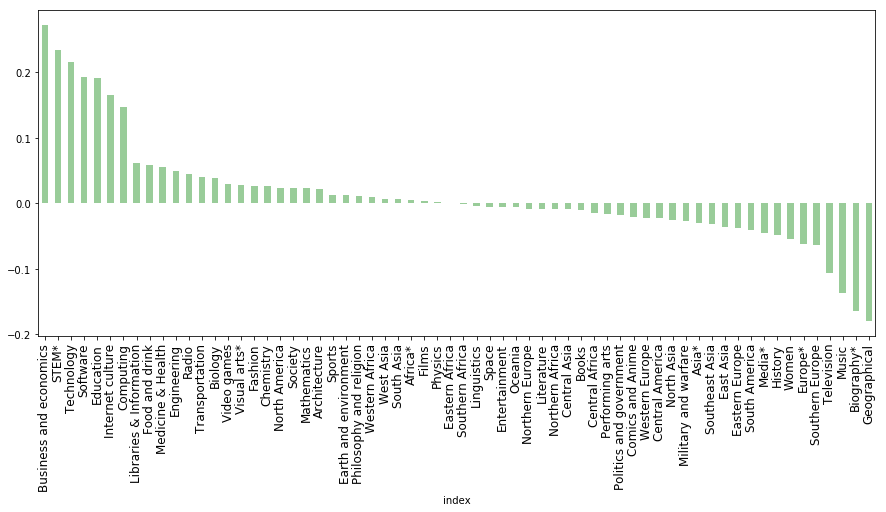

In [4]:
corr = expanded_features.corr()[['ctrate']].sort_values("ctrate", ascending=False).reset_index()
df = corr[~corr['index'].isin(['offset_time_median', 'offset_time_mean', 'ctrate'])]
p = df.plot(x="index", y="ctrate", kind="bar", figsize=(15,6), color="g", alpha=0.4)

p.legend().remove()
_ = p.set_xticklabels([n.split(".")[-1] for n in df['index'].tolist()], 
                       rotation=90, fontsize=12)

### Regression to predict the CT rate:

The CT rate is binarized low/high by using the median as threshold.

Optimization terminated successfully.
         Current function value: 0.552754
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               111828
Model:                          Logit   Df Residuals:                   111770
Method:                           MLE   Df Model:                           57
Date:                Fri, 22 Jan 2021   Pseudo R-squ.:                  0.2025
Time:                        12:22:12   Log-Likelihood:                -61813.
converged:                       True   LL-Null:                       -77513.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                     

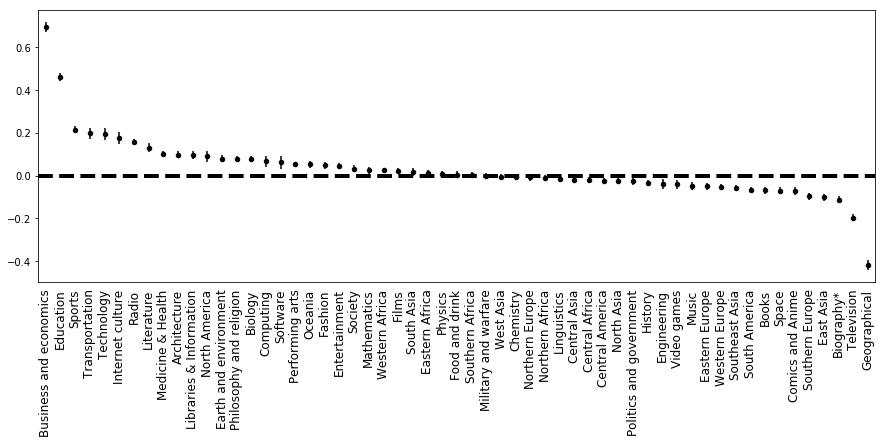

In [5]:
import statsmodels.api as sm

X = pd.DataFrame()

# White list to remove mixed topics (marked with *), except for Biography*
wl = ['Culture.Biography.Biography*',
               'Culture.Food and drink', 'Culture.Internet culture', 'Culture.Linguistics',
               'Culture.Literature', 'Culture.Media.Books', 'Culture.Media.Entertainment',
               'Culture.Media.Films', 'Culture.Media.Music', 'Culture.Media.Radio',
               'Culture.Media.Software', 'Culture.Media.Television', 'Culture.Media.Video games',
               'Culture.Performing arts', 'Culture.Philosophy and religion', 'Culture.Sports',
               'Culture.Visual arts.Architecture', 'Culture.Visual arts.Comics and Anime',
               'Culture.Visual arts.Fashion', 'Geography.Geographical',
                'Geography.Regions.Africa.Central Africa',
               'Geography.Regions.Africa.Eastern Africa', 'Geography.Regions.Africa.Northern Africa',
               'Geography.Regions.Africa.Southern Africa', 'Geography.Regions.Africa.Western Africa',
               'Geography.Regions.Americas.Central America', 'Geography.Regions.Americas.North America',
               'Geography.Regions.Americas.South America', 
               'Geography.Regions.Asia.Central Asia', 'Geography.Regions.Asia.East Asia',
               'Geography.Regions.Asia.North Asia', 'Geography.Regions.Asia.South Asia',
               'Geography.Regions.Asia.Southeast Asia', 'Geography.Regions.Asia.West Asia',
               'Geography.Regions.Europe.Eastern Europe', 
               'Geography.Regions.Europe.Northern Europe', 'Geography.Regions.Europe.Southern Europe',
               'Geography.Regions.Europe.Western Europe', 'Geography.Regions.Oceania',
               'History and Society.Business and economics', 'History and Society.Education',
               'History and Society.History', 'History and Society.Military and warfare',
               'History and Society.Politics and government', 'History and Society.Society',
               'History and Society.Transportation', 'STEM.Biology', 'STEM.Chemistry',
               'STEM.Computing', 'STEM.Earth and environment', 'STEM.Engineering', 'STEM.Libraries & Information',
               'STEM.Mathematics', 'STEM.Medicine & Health', 'STEM.Physics', 
               'STEM.Space', 'STEM.Technology']

for f in wl:
    X[f] = (expanded_features[f]-expanded_features[f].mean())/expanded_features[f].std()
    
y = expanded_features[['ctrate']]

# Get CTR median
m = np.median(y.ctrate)

# Binary outcome
mod = sm.Logit([1 if i >=m else 0 for i in y.ctrate ], sm.add_constant(X))
res = mod.fit()
print(res.summary())

# ===========================
# PLOT
# ===========================

err_series = res.params - res.conf_int()[0]

coef_df_click = pd.DataFrame({'coef': res.params.values[1:],
                        'err': err_series.values[1:],
                        'varname': err_series.index.values[1:]
                       }).sort_values("coef", ascending=False)

fig, ax = plt.subplots(figsize=(15, 5))
coef_df_click.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_df_click.shape[0]), 
           marker='o', s=20, 
           y=coef_df_click['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')

_ = ax.set_xticklabels([n.split(".")[-1] for n in coef_df_click['varname'].tolist()], 
                       rotation=90, fontsize=12)

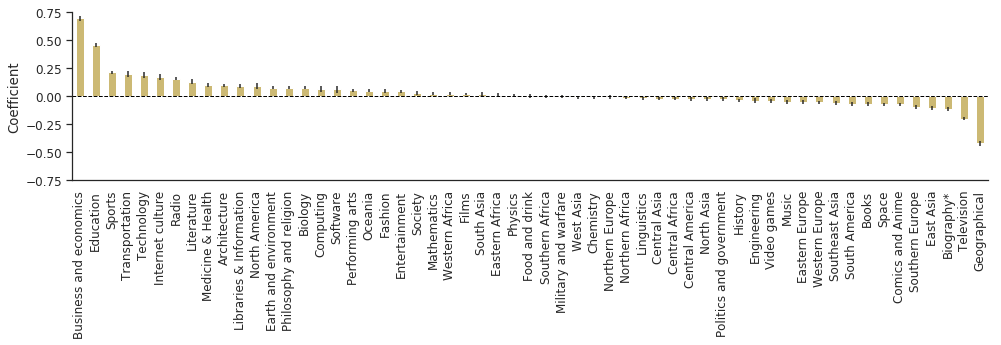

In [6]:
import seaborn as sns

sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})


fig, ax = plt.subplots(figsize=(14, 5))
coef_df_click.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='y', 
             yerr='err', legend=False)
ax.set_ylabel('Coefficient')
ax.set_xlabel('')

ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
ax.xaxis.set_ticks_position('none')

_ = ax.set_xticklabels([n.split(".")[-1] for n in coef_df_click['varname'].tolist()], 
                       rotation=90, fontsize=12)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim((-0.75,0.75))

plt.tight_layout()

# plt.savefig('click_coefficients.pdf', bbox_inches='tight')

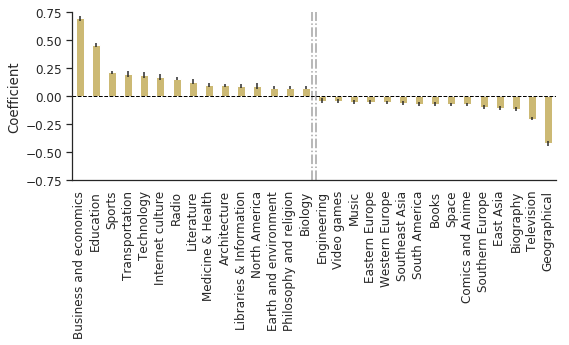

In [7]:
import seaborn as sns


sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

top_bottom = coef_df_click.head(15).append(coef_df_click.tail(15))


fig, ax = plt.subplots(figsize=(8, 5))
top_bottom.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='y', 
             yerr='err', legend=False)
ax.set_ylabel('Coefficient')
ax.set_xlabel('')

ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
ax.xaxis.set_ticks_position('none')

_ = ax.set_xticklabels([n.split(".")[-1].replace("*", "") for n in top_bottom['varname'].tolist()], 
                       rotation=90, fontsize=12)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim((-0.75,0.75))
ax.axvline(x=14.4, c="k", alpha=0.4, linestyle="-.")
ax.axvline(x=14.6, c="k", alpha=0.4, linestyle="-.")
plt.tight_layout()

# plt.savefig('click_coefficients_one_column.pdf', bbox_inches='tight')

-----------

### Linear Regression to predict the click time:

In [8]:
expanded_features = pd.read_pickle("page_topics_ctrate_expanded_balanced_time.pkl")

Get simple regression between time and each topic value:

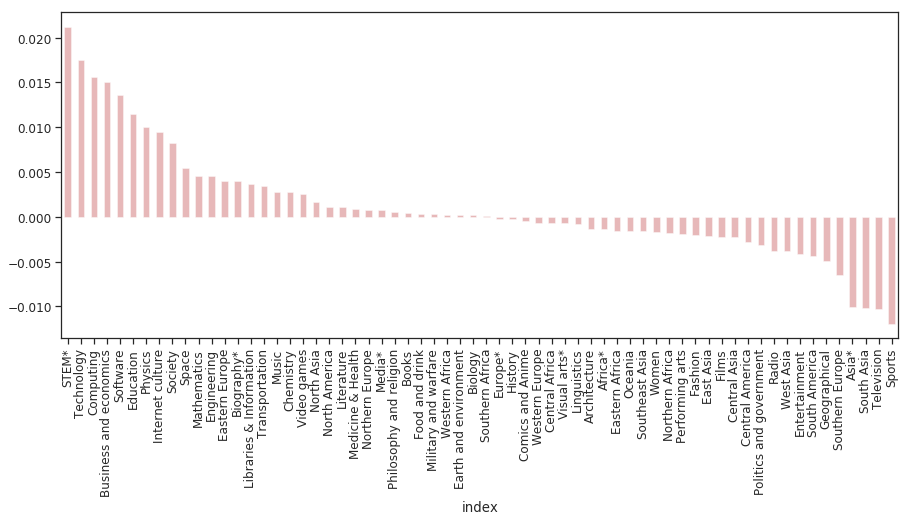

In [9]:
corr = expanded_features.corr()[['offset_time_mean']].sort_values("offset_time_mean", ascending=False).reset_index()
df = corr[~corr['index'].isin(['offset_time_median', 'offset_time_mean', 'ctrate'])]
p = df.plot(x="index", y="offset_time_mean", kind="bar", figsize=(15,6), color="r", alpha=0.4)

p.legend().remove()
_ = p.set_xticklabels([n.split(".")[-1] for n in df['index'].tolist()], 
                       rotation=90, fontsize=12)

Train linear regression:

In [10]:
import statsmodels.api as sm

X = pd.DataFrame()

features = expanded_features[expanded_features.offset_time_median>0]

for f in wl:
    X[f] = features[f]-features[f].mean()/features[f].std()

# Target variable is log-transformed
y = np.log1p(features['offset_time_median'])

mod = sm.OLS(y, sm.add_constant(X))
res = mod.fit()
print(res.summary())

err_series = res.params - res.conf_int()[0]

coef_df_speed = pd.DataFrame({'coef': res.params.values[1:],
                        'err': err_series.values[1:],
                        'varname': err_series.index.values[1:]
                       }).sort_values("coef", ascending=False)

                            OLS Regression Results                            
Dep. Variable:     offset_time_median   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     170.8
Date:                Fri, 22 Jan 2021   Prob (F-statistic):               0.00
Time:                        12:22:17   Log-Likelihood:            -1.3258e+05
No. Observations:               98419   AIC:                         2.653e+05
Df Residuals:                   98361   BIC:                         2.658e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

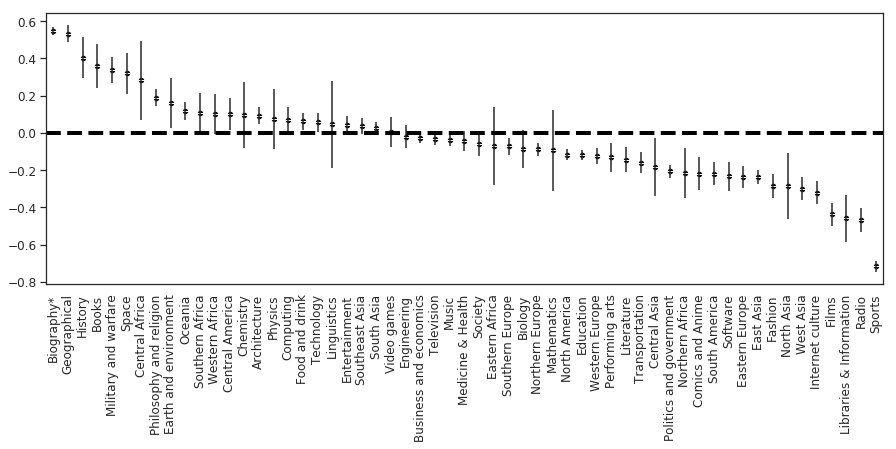

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
coef_df_speed.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_df_speed.shape[0]), 
           marker='o', s=20, 
           y=coef_df_speed['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')

_ = ax.set_xticklabels([n.split(".")[-1] for n in coef_df_speed['varname'].tolist()], 
                       rotation=90, fontsize=12)

Text(15, 0.5, 'Slow')

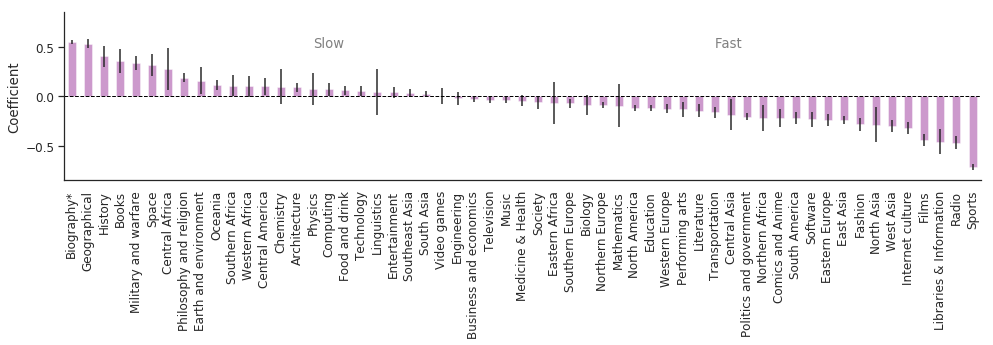

In [12]:
import seaborn as sns


sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

fig, ax = plt.subplots(figsize=(14, 5))
coef_df_speed.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='purple', 
             yerr='err', legend=False, alpha=0.4)
ax.set_ylabel('Coefficient')
ax.set_xlabel('')
ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
ax.xaxis.set_ticks_position('none')

_ = ax.set_xticklabels([n.split(".")[-1] for n in coef_df_speed['varname'].tolist()], 
                       rotation=90, fontsize=12)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim((-0.85,0.85))

plt.tight_layout()

ax.annotate("Fast", (40, 0.5), color='grey')
ax.annotate("Slow", (15, 0.5), color='grey')

# plt.savefig('time_coefficients.pdf', bbox_inches='tight')

Text(7, 0.55, 'Slow')

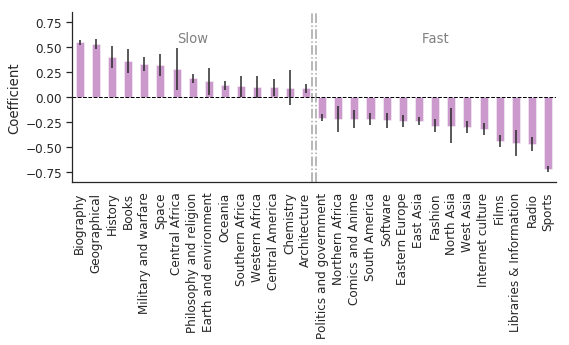

In [13]:
import seaborn as sns


sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

top_bottom = coef_df_speed.head(15).append(coef_df_speed.tail(15))

fig, ax = plt.subplots(figsize=(8, 5))
top_bottom.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='purple', 
             yerr='err', legend=False, alpha=0.4)
ax.set_ylabel('Coefficient')
ax.set_xlabel('')
ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
ax.xaxis.set_ticks_position('none')

_ = ax.set_xticklabels([n.split(".")[-1].replace("*","") for n in top_bottom['varname'].tolist()], 
                       rotation=90, fontsize=12)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim((-0.85,0.85))

plt.tight_layout()

ax.axvline(x=14.4, c="k", alpha=0.4, linestyle="-.")
ax.axvline(x=14.6, c="k", alpha=0.4, linestyle="-.")

ax.annotate("Fast", (22, 0.55), color='grey', ha="center")
ax.annotate("Slow", (7, 0.55), color='grey', ha="center")

# plt.savefig('time_coefficients_one_column.pdf', bbox_inches='tight')

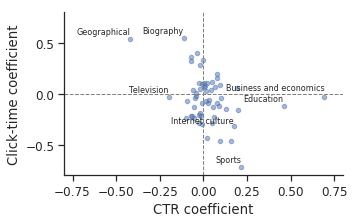

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

df = coef_df_click.merge(coef_df_speed, on="varname")

sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

df.plot(kind="scatter", x="coef_x", y="coef_y", alpha=0.5, c="b", ax=ax)
ax.axhline(y=0, linestyle='--', color='grey', linewidth=1)
ax.axvline(x=0, linestyle='--', color='grey', linewidth=1)
ax.set_xlabel("CTR coefficient")
ax.set_ylabel("Click-time coefficient")

labels = [ 
          "Geography.Geographical", 
          "History and Society.Education", "Culture.Media.Television", "Culture.Sports",
          "Culture.Biography.Biography*"]
for label in labels:
    row = df[df.varname==label]
    x=row.iloc[0].coef_x
    y=row.iloc[0].coef_y+0.05
    ax.annotate(label.split(".")[-1].replace("*", ""), (x,y), fontsize=8, ha="right")
    
row = df[df.varname=="History and Society.Business and economics"]
x=row.iloc[0].coef_x
y=row.iloc[0].coef_y+0.07
ax.annotate("Business and economics", (x,y), fontsize=8, ha="right")

row = df[df.varname=="Culture.Internet culture"]
x=row.iloc[0].coef_x
y=row.iloc[0].coef_y+0.03
ax.annotate("Internet culture", (x,y), fontsize=8, ha="right")

ax.set_xlim((-0.8,0.8))
ax.set_ylim((-0.8,0.8))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('coff_ctrate_vs_time.pdf', bbox_inches='tight')